In [6]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial

import shap
import optuna as opt
from lightgbm import LGBMRegressor

from func import Training, AdstockGeometric

plt.style.use('fivethirtyeight')

ImportError: cannot import name 'AdstockGeometric' from 'func' (/Users/xuankhang.do/PycharmProjects/ML-learning-journey/analytic_pipeline/marketing_mix_effects/func.py)

In [2]:
# Data: Ads
path = Path.home() / 'OneDrive - Seagroup/mkt/mkt_mix'
df = pd.read_csv(path / 'ad_fb.csv', parse_dates=['DATE'])
print(df.shape)

(208, 12)


In [3]:
df

,DATE,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2.754372e+06,167687.6,0,95463.666667,7.290385e+07,0.000000,0,8125009,228213.987444,na,19401.653846
1,2015-11-30,2.584277e+06,214600.9,0,0.000000,1.658110e+07,29511.715457,31000,7901549,34258.573511,na,14791.000000
2,2015-12-07,2.547387e+06,0.0,248022,3404.000000,4.995477e+07,36132.358958,28400,8300197,127691.261335,na,14544.000000
3,2015-12-14,2.875220e+06,625877.3,0,132600.000000,3.164930e+07,36804.210958,31900,8122883,84014.720306,na,2800.000000
4,2015-12-21,2.215953e+06,0.0,520005,0.000000,8.802269e+06,28401.744069,27100,7105985,20687.478156,na,15478.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
203,2019-10-14,2.456240e+06,0.0,60433,153723.666667,0.000000e+00,152840.323412,112100,7612762,0.000000,na,28157.000000
204,2019-10-21,2.182825e+06,154917.6,0,0.000000,5.688196e+07,103680.047821,103700,6701667,133624.575524,na,10644.000000
205,2019-10-28,2.377707e+06,21982.5,14094,17476.000000,0.000000e+00,138387.704138,114700,7688920,0.000000,na,9597.000000
206,2019-11-04,2.732825e+06,22453.0,0,24051.333333,0.000000e+00,151707.990462,134100,8815710,0.000000,na,90189.000000


[1]	valid_0's l1: 548145
[2]	valid_0's l1: 498726
[3]	valid_0's l1: 454342
[4]	valid_0's l1: 417663
[5]	valid_0's l1: 383955
[6]	valid_0's l1: 357048
[7]	valid_0's l1: 330753
[8]	valid_0's l1: 305879
[9]	valid_0's l1: 286850
[10]	valid_0's l1: 268286
[11]	valid_0's l1: 252720
[12]	valid_0's l1: 241162
[13]	valid_0's l1: 229590
[14]	valid_0's l1: 218927
[15]	valid_0's l1: 211559
[16]	valid_0's l1: 204870
[17]	valid_0's l1: 202638
[18]	valid_0's l1: 200167
[19]	valid_0's l1: 197786
[20]	valid_0's l1: 195643
[21]	valid_0's l1: 189710
[22]	valid_0's l1: 185156
[23]	valid_0's l1: 186092
[24]	valid_0's l1: 181735
[25]	valid_0's l1: 181746
[26]	valid_0's l1: 179160
[27]	valid_0's l1: 175275
[28]	valid_0's l1: 176492
[29]	valid_0's l1: 174850
[30]	valid_0's l1: 174130
[31]	valid_0's l1: 174783
[32]	valid_0's l1: 175636
[33]	valid_0's l1: 174615
[34]	valid_0's l1: 174037
[35]	valid_0's l1: 172283
[36]	valid_0's l1: 170038
[37]	valid_0's l1: 169156
[38]	valid_0's l1: 169520
[39]	valid_0's l1: 16

Result: 100%|██████████| 3/3 [00:00<00:00, 971.13it/s]

102060.93456032715
166962.12698412652
162033.73611111147


DECOMP.RSSD: 0.3200988796490891


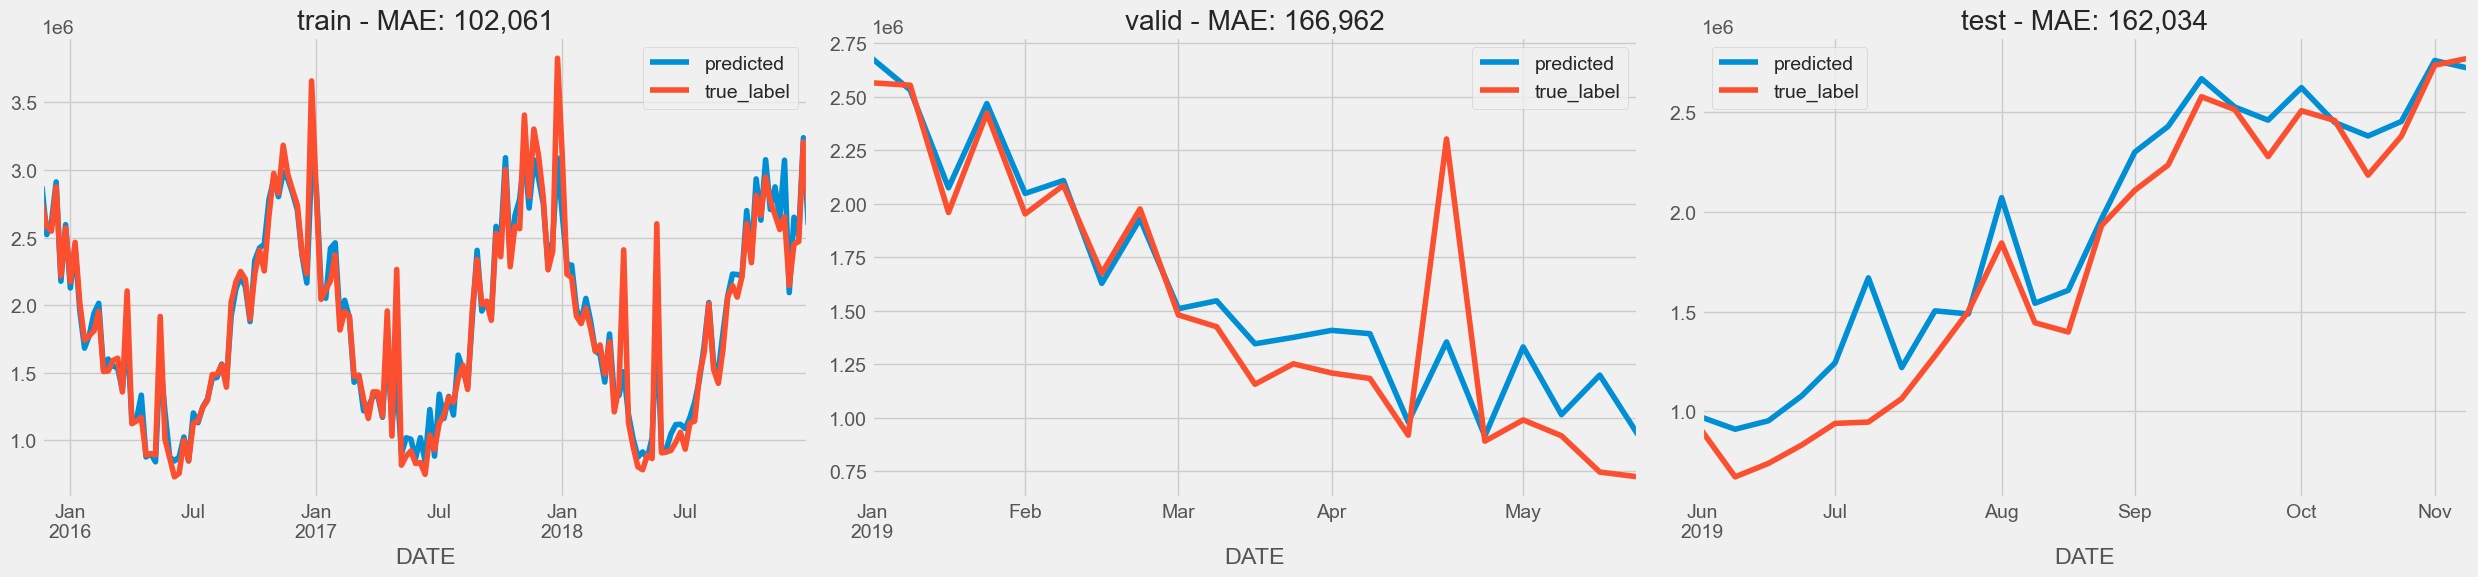

In [5]:
# train
media_channels = ["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"]
organic_channels = ["newsletter"]
all_features = ["competitor_sales_B"] + media_channels + organic_channels
label_name = 'revenue'
train = Training(all_features, label_name, df)
X, y, dataset = train.train_split('2019-01-01', '2019-06-01')
sample = df[all_features]

params = {
    'objective': 'regression',
    'metric': 'mae',
    'random_state': 42,
    # 'n_estimators': 2000,
}
# if search := True:
#     best_param = train.search_params(n_trials=50)
#     params |= best_param
model = LGBMRegressor(**params)
model.fit(X['train'], y['train'], eval_set=[(X['valid'], y['valid'])])

# result
col_key = ['DATE']
result = train.results(model, col_key)
feature_importance = train.feature_importance(model)
train.plot(result, path / 'media/pred.png')

# shap explainer
explainer = shap.TreeExplainer(model)
df_shap = pd.DataFrame(explainer.shap_values(X['test']), columns=all_features)
spend_effect_share = train.shap_effects(df_shap, all_features)
decomp_rssd = train.rssd(spend_effect_share['contribution'].values, spend_effect_share['distribution'].values)
print(f"DECOMP.RSSD: {decomp_rssd}")

RMSE: 217680.57034117772
MAPE: 0.1367420722262281
R2: 0.9020196602443928


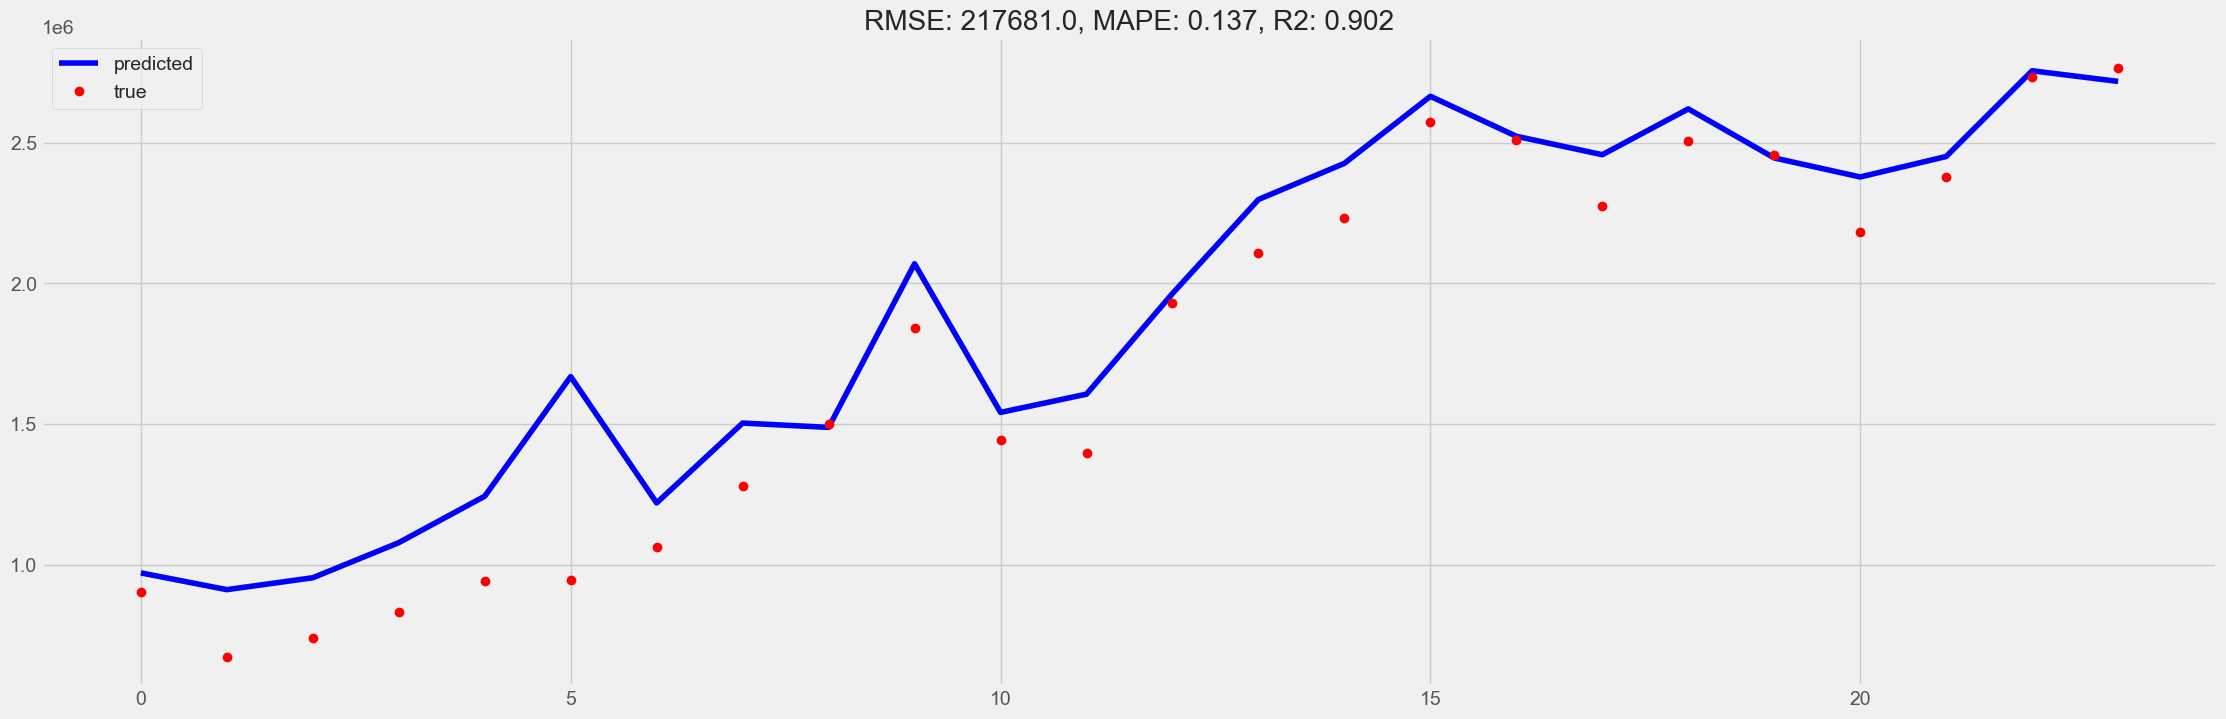

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

data = 'test'
rmse_metric = mean_squared_error(y_true=result[data]["true_label"], y_pred=result[data]["predicted"], squared=False)
mape_metric = mean_absolute_percentage_error(y_true=result[data]["true_label"], y_pred=result[data]["predicted"])
r2_metric = r2_score(y_true=result[data]["true_label"], y_pred=result[data]["predicted"])

print(f'RMSE: {rmse_metric}')
print(f'MAPE: {mape_metric}')
print(f'R2: {r2_metric}')


fig, ax = plt.subplots(figsize = (25, 8))
ax.plot(result[data]["predicted"], color="blue", label="predicted")
ax.plot(result[data]["true_label"], 'ro', label="true")
plt.title(f"RMSE: {np.round(rmse_metric)}, MAPE: {np.round(mape_metric, 3)}, R2: {np.round(r2_metric,3)}")
ax.legend()

In [16]:
spend_effect_share

,test_set_channels,contribution,distribution
0,competitor_sales_B,0.661891,0.952553
1,tv_S,0.093853,0.008498
2,ooh_S,0.018058,0.003517
3,print_S,0.060303,0.004183
4,facebook_S,0.054717,0.013615
5,search_S,0.084312,0.012362
6,newsletter,0.026866,0.005272


<Axes: ylabel='test_set_channels'>

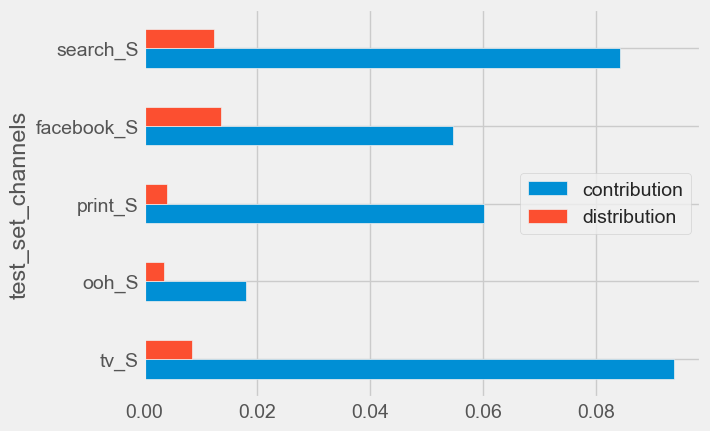

In [18]:
spend_effect_share.query(f'test_set_channels == {media_channels}').set_index('test_set_channels').plot(kind='barh')

In [ ]:
sns.barplot(data=spend_effect_share, x='test_set_channels', )

In [ ]:
def optuna_trial(trial, data, media_features, adstock_features_params,
                 is_multiobjective: bool = False):
    # Clone
    data_tmp = data.copy()

    # Ad
    adstock_alphas = {}
    for feature, val in adstock_features_params.items():
        # Adstock
        min_, max_ = val
        adstock_alpha = trial.suggest_uniform(f"adstock_alpha_{feature}", min_, max_)
        adstock_alphas[feature] = adstock_alpha
        # Fit
        x_feature = data_tmp[feature].values.reshape(-1, 1)
        data_tmp[feature] = AdstockGeometric(alpha=adstock_alpha).fit_transform(x_feature)

    # Model:Split
    train = Training(all_features, label_name, data_tmp)
    X, y, dataset = train.train_split('2019-01-01', '2019-06-01')

    params = {
        'objective': ['poisson', 'gamma'],
        'metric': ['mae', 'mape', 'rmse'],
        'random_state': 42,
        'verbose': -1,
        'n_estimators': trial.suggest_int("n_estimators", 100, 8000),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    scores = []
    rssds = []
    model = LGBMRegressor(**params)
    model.fit(X['train'], y['train'], eval_set=[(X['valid'], y['valid'])])
    pred = model.predict(X['test'])
    rmse = mean_squared_error(y_true=y['test'], y_pred=pred, squared=False)
    scores.append(rmse)

    if is_multiobjective:
        explainer = shap.TreeExplainer(model)
        df_shap = pd.DataFrame(explainer.shap_values(X['test']), columns=media_features)
        spend_effect_share = train.shap_effects(df_shap, media_features)
        decomp_rssd = train.rssd(spend_effect_share['contribution'].values,
                                 spend_effect_share['distribution'].values)
        rssds.append(decomp_rssd)

    trial.set_user_attr('scores', scores)
    trial.set_user_attr('params', params)
    trial.set_user_attr('adstock_alphas', adstock_alphas)
    trial.set_user_attr('rssds', rssds)

    if not is_multiobjective:
        return np.mean(scores)
    return np.mean(scores), np.mean(rssds)


def optuna_optimize(data, adstock_features, adstock_features_params, media_features,
                    n_trials: int = 2000, multi_objective: bool = False, seed: int = 42):
    print(f'data size: {len(data)}')
    print(f'media features: {media_features}')
    print(f'adstock features: {adstock_features}')
    print(f'is_multiobjective: {multi_objective}')

    if not multi_objective:
        study_mmm = opt.create_study(direction='minimize', sampler=opt.samplers.TPESampler(seed=seed))
    else:
        study_mmm = opt.create_study(directions=['minimize', 'minimize'],
                                     sampler=opt.samplers.NSGAIISampler(seed=seed))
    optimization_function = partial(optuna_trial,
                                    data=data,
                                    adstock_features=adstock_features,
                                    adstock_features_params=adstock_features_params,
                                    media_features=media_features,
                                    is_multiobjective=multi_objective)
    study_mmm.optimize(optimization_function, n_trials=n_trials, show_progress_bar=True)

    return study_mmm

In [ ]:
organic_channels = ['newsletter']
media_channels = ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S']
features = ['competitor_sales_B', 'events'] + media_channels + organic_channels
target = 'revenue'
adstock_features = media_channels + organic_channels
adstock_features_params = {
    'tv_S_adstock': (0.3, 0.8),
    'ooh_S_adstock': (0.1, 0.4),
    'print_S_adstock': (0.1, 0.4),
    'facebook_S_adstock': (0.0, 0.4),
    'search_S_adstock': (0.0, 0.3),
    'newsletter_adstock': (0.1, 0.4),
}

experiment = optuna_optimize(trials=2000,
                             data=df,
                             target=target,
                             features=features,
                             adstock_features=media_channels + organic_channels,
                             adstock_features_params=adstock_features_params,
                             media_features=media_channels,
                             multi_objective=False)